In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [ ]:
image_path = r"296059.jpg"


img = plt.imread(image_path)


if img.ndim == 3:
    img = img.mean(axis=2)


x_true = img.astype(float)
x_true /= x_true.max()


print("Image shape:", x_true.shape)

Image shape: (321, 481)


In [3]:
def gaussian_kernel(size=9, sigma=2.0):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel


kernel = gaussian_kernel(size=9, sigma=2.0)

In [4]:
def A_op(x):
    return convolve2d(x, kernel, mode="same", boundary="symm")


def AT_op(x):
    flipped = np.flipud(np.fliplr(kernel))
    return convolve2d(x, flipped, mode="same", boundary="symm")

In [5]:
noise_std = 0.01
Ax = A_op(x_true)
eps = noise_std * np.random.randn(*Ax.shape)
y = Ax + eps

In [6]:
def tikhonov_operator(y, lam, n_iter=200, tau=0.1):
    x = np.zeros_like(y)
    for _ in range(n_iter):
        grad = AT_op(A_op(x) - y) + lam * x
        x -= tau * grad
    return x

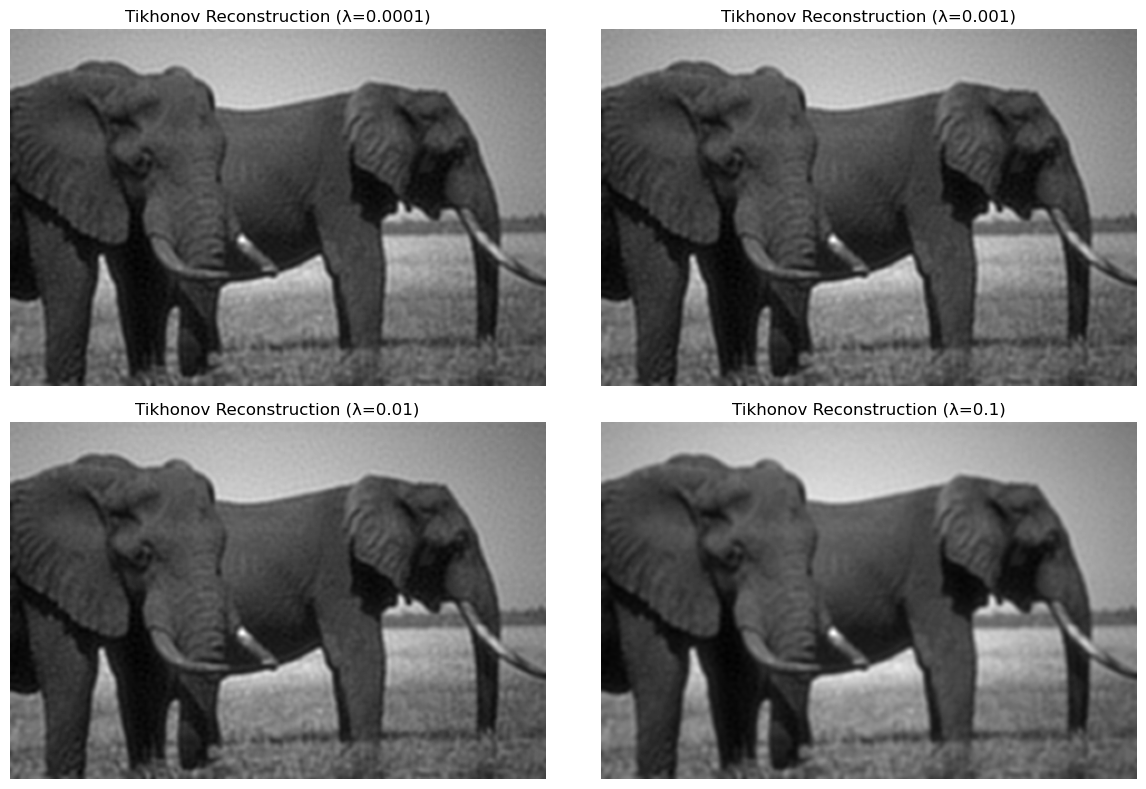

In [7]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1]


plt.figure(figsize=(12,8))
for i, lam in enumerate(lambdas):
    x_rec = tikhonov_operator(y, lam)
    plt.subplot(2,2,i+1)
    plt.imshow(x_rec, cmap="gray")
    plt.title(f"Tikhonov Reconstruction (λ={lam})")
    plt.axis("off")


plt.tight_layout()
plt.show()